# table of contents

# loading necessarily packages

# loading and preparing data

In [ ]:

import torch
import torchvision
from torchvision import transforms
from collections import defaultdict
import numpy as np

# Define transforms: convert image to Tensor (shape: [1, 28, 28], values in [0, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load EMNIST Letters training and test datasets
train_dataset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

# extract a fixed number of samples per class from a dataset
def extract_balanced_subset(dataset, samples_per_class):
    class_data = defaultdict(list)
    for img, label in dataset:
        if len(class_data[label]) < samples_per_class:
            class_data[label].append(img.view(-1))  # Flatten 28x28 image to 784-dim vector
        if all(len(class_data[i]) >= samples_per_class for i in range(1, 27)):
            break
    return class_data

# Extract training (200 per class) and test (20 per class) data
train_data_per_class = extract_balanced_subset(train_dataset, 200)
test_data_per_class = extract_balanced_subset(test_dataset, 20)

# Build training matrices A_i for each class (shape: 784 × 200)
A_matrices = {}
for label in range(1, 27):  # EMNIST Letters labels go from 1 to 26 (A-Z)
    A_matrices[label] = torch.stack(train_data_per_class[label], dim=1)  # shape: (784, 200)

# Build test vectors and their true labels
test_vectors = []
test_labels = []

for label in range(1, 27):
    for img in test_data_per_class[label]:
        test_vectors.append(img)
        test_labels.append(label)

test_vectors = torch.stack(test_vectors)  # shape: (520, 784)
test_labels = torch.tensor(test_labels)   # shape: (520,)

# Convert all data to NumPy arrays for use in QR decomposition
A_matrices_np = {k: v.numpy() for k, v in A_matrices.items()}
test_vectors_np = test_vectors.numpy()
test_labels_np = test_labels.numpy()

print("✅ Data preparation completed!")
print(f"Train matrix A1 shape: {A_matrices_np[1].shape}  (should be 784 x 200)")
print(f"Test vector shape: {test_vectors_np[0].shape}  (should be 784, one sample)")
print(f"Total test samples: {len(test_labels_np)}")


100%|██████████| 562M/562M [00:46<00:00, 12.2MB/s]


✅ Data preparation completed!
Train matrix A1 shape: (784, 200)  (should be 784 x 200)
Test vector shape: (784,)  (should be 784, one sample)
Total test samples: 520


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# implementing householder method for QR decomposition

In [ ]:
def householder_qr(A):
    """
    QR decomposition using Householder reflections.
    A: (m x n) matrix
    Returns:
        Q: (m x m)
        R: (m x n)

    Q = H1 * H2 * ... * Hk
    R = Hk * ... * H2 * H1 * A
    Returns Q, R such that A = Q @ R
    """
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)

    for k in range(n):
        x = R[k:, k]
        norm_x = np.linalg.norm(x)
        sgn = np.sign(x[0]) if x[0] != 0 else 1
        e1 = np.zeros_like(x)
        e1[0] = 1.0
        v = x + sgn * norm_x * e1
        v = v / np.linalg.norm(v)

        H_k = np.eye(m)
        H_k_sub = np.eye(len(x)) - 2.0 * np.outer(v, v)
        H_k[k:, k:] = H_k_sub

        R = H_k @ R      # R = H_i * ... * H_1 * A
        Q = Q @ H_k      # Q = H_1 * H_2 * ...

    return Q, R


#  Precompute QR for all A_i using householder_qr
qr_cache = {}
for i in range(1, 27):
    A = A_matrices_np[i]
    Q, R = householder_qr(A)  # Your own implementation
    qr_cache[i] = (Q, R)


In [ ]:
# for checking QR decomposition
for label in range(1, 27):
    Q_1, R_1 = qr_cache[label]
    error = np.linalg.norm(A_matrices_np[label] - Q_1 @ R_1)
    print(f"Label {label} - Norm of difference :", error)

Label 1 - Norm of difference : 1.3375032289880898e-05
Label 2 - Norm of difference : 9.942161800838035e-06
Label 3 - Norm of difference : 2.131757859001232e-05
Label 4 - Norm of difference : 6.474939757694908e-06
Label 5 - Norm of difference : 6.504250196418339e-06
Label 6 - Norm of difference : 1.8919716223337196e-05
Label 7 - Norm of difference : 3.8747736502553166e-05
Label 8 - Norm of difference : 3.186842019037311e-05
Label 9 - Norm of difference : 2.5767871911166323e-05
Label 10 - Norm of difference : 4.494666763845336e-06
Label 11 - Norm of difference : 1.3247419020018304e-05
Label 12 - Norm of difference : 7.756376089498286e-06
Label 13 - Norm of difference : 2.9396893330798723e-05
Label 14 - Norm of difference : 7.011059351737479e-06
Label 15 - Norm of difference : 1.281334876740979e-05
Label 16 - Norm of difference : 2.7474613728143167e-06
Label 17 - Norm of difference : 1.9778517756295275e-05
Label 18 - Norm of difference : 3.4284901763588e-05
Label 19 - Norm of difference :

In [ ]:
# Define solver using cached Q, R
def solve_least_squares_qr(Q, R, z, A):
    """
    Solves the least-squares problem: min_x ||z - Ax||_2 using QR decomposition.

    Parameters:
        A: numpy.ndarray of shape (m, n), matrix of training samples for a class
        z: numpy.ndarray of shape (m,), a new test sample vector

    Returns:
        residual: the L2-norm ||z - Ax||_2, representing distance from column space of A
    """
    Qt_z = Q.T @ z  # Project z onto Q^T
    x = np.linalg.lstsq(R, Qt_z, rcond=None)[0] # Solve R x = Q^T z
    residual = np.linalg.norm(z - A @ x)  # Compute residual norm ||z - Ax||
    return residual

#  Predict using precomputed QR decompositions
predicted_labels = []

for idx, z in enumerate(test_vectors_np):
    min_residual = float('inf')
    pred_class = -1

    for i in range(1, 27):
        Q, R = qr_cache[i]
        A = A_matrices_np[i]
        residual = solve_least_squares_qr(Q, R, z, A)

        if residual < min_residual:
            min_residual = residual
            pred_class = i

    predicted_labels.append(pred_class)

predicted_labels = np.array(predicted_labels)

# acuuracy
accuracy = np.mean(predicted_labels == test_labels_np)
# accuracy = np.mean(predicted_labels == test_labels_np[:len(predicted_labels)])

print(f"Classification accuracy: {accuracy * 100:.2f}%")


# Example predictions (First 10)
for i in range(10):
    print(f"Test #{i}: True = {test_labels_np[i]}, Predicted = {predicted_labels[i]}")


Classification accuracy: 70.58%
Test #0: True = 1, Predicted = 1
Test #1: True = 1, Predicted = 1
Test #2: True = 1, Predicted = 1
Test #3: True = 1, Predicted = 21
Test #4: True = 1, Predicted = 1
Test #5: True = 1, Predicted = 1
Test #6: True = 1, Predicted = 1
Test #7: True = 1, Predicted = 1
Test #8: True = 1, Predicted = 1
Test #9: True = 1, Predicted = 1


In [ ]:
import pandas as pd

# Create a dictionary to store per-class results
class_accuracies = {}

for label in range(1, 27):  # EMNIST letters: 1 to 26
    # Get indices where true label is 'label'
    indices = np.where(test_labels_np == label)[0]
    total = len(indices)
    correct = np.sum(predicted_labels[indices] == label)
    acc = correct / total
    class_accuracies[label] = acc

# map to letters A–Z
letters = [chr(ord('A') + i - 1) for i in range(1, 27)]
results_df = pd.DataFrame({
    "Class": letters,
    "Label": list(range(1, 27)),
    "Accuracy": [class_accuracies[i] for i in range(1, 27)]
})

print(results_df)



   Class  Label  Accuracy
0      A      1      0.75
1      B      2      0.70
2      C      3      0.65
3      D      4      0.40
4      E      5      0.75
5      F      6      0.50
6      G      7      0.55
7      H      8      0.65
8      I      9      0.85
9      J     10      0.60
10     K     11      0.90
11     L     12      0.30
12     M     13      0.85
13     N     14      0.75
14     O     15      0.85
15     P     16      0.80
16     Q     17      0.45
17     R     18      0.85
18     S     19      0.85
19     T     20      0.70
20     U     21      0.60
21     V     22      0.90
22     W     23      0.85
23     X     24      0.75
24     Y     25      0.65
25     Z     26      0.90


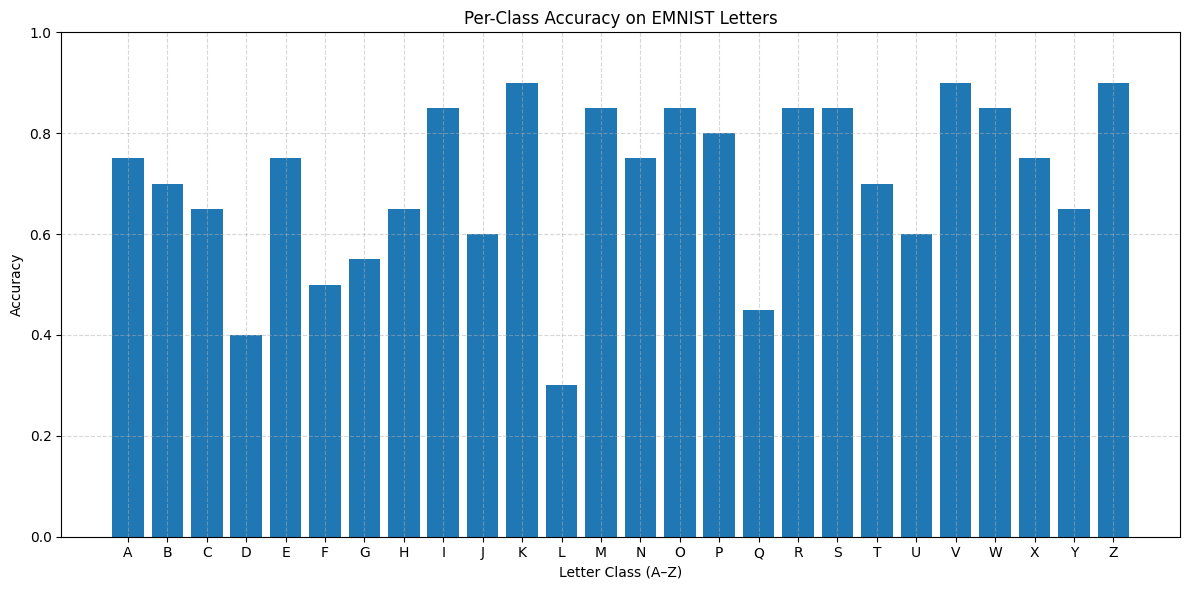

In [ ]:
import matplotlib.pyplot as plt

letters = [chr(ord('A') + i - 1) for i in range(1,27)]
accuracies = [np.mean(predicted_labels[test_labels_np == (i )] == (i )) for i in range(1,27)]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(letters, accuracies)
plt.ylim(0, 1)
plt.xlabel("Letter Class (A–Z)")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy on EMNIST Letters")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# implementing QR decomposition with givens rotation

In [ ]:
#  extraxt 20 extra sample for each class
extra_train_data_per_class = extract_balanced_subset(train_dataset, 220)
extra_columns_per_class = {}
for label in range(1, 27):
    extra_cols = extra_train_data_per_class[label][200:]
    extra_columns_per_class[label] = torch.stack(extra_cols, dim=1).numpy()


In [ ]:
def givens(a, b):
    """
    Compute the Givens rotation matrix elements c and s such that:
    [ c  s]   [a]   [r]
    [-s  c] * [b] = [0]

    Parameters:
    a (float): The element to remain.
    b (float): The element to be zeroed out.

    Returns:
    c (float): Cosine component of the rotation.
    s (float): Sine component of the rotation.
    """
    if b == 0:
        c = 1.0
        s = 0.0
    else:
        if abs(b) > abs(a):
            tau = -a / b
            s = 1 / np.sqrt(1 + tau**2)
            c = s * tau
        else:
            tau = -b / a
            c = 1 / np.sqrt(1 + tau**2)
            s = c * tau
    return c, s


In [ ]:


def update_qr_with_new_column(Q, R, x):
    """
    Given the current full QR factorization of A:
         A = Q @ R,
    where Q is m×m orthogonal and R is stored as an m×current_n matrix that is upper trapezoidal
    (i.e. only the first current_n rows are nonzero),
    update the factors by appending a new column x (of length m) to A.

    This implements the update for the case where the new column is appended at the end.

    Inputs:
       Q : m×m orthogonal matrix.
       R : m×current_n matrix (with active part in the first current_n rows).
       x : m-vector, the new column to append.

    Returns:
       Q_new : Updated Q (still m×m).
       R_new : Updated R, now an m×(current_n+1) matrix.
    """

    m = Q.shape[0]
    current_n = R.shape[1]  # Number of columns currently in A
    new_n = current_n + 1   # After appending, the new column index to be activated

    # Compute projection of x onto the Q space.
    u = Q.T @ x  # u is an m-vector

    # Form augmented R by appending u as the new column.
    R_aug = np.hstack((R, u.reshape(-1, 1)))  # R_aug has shape m×(current_n+1)

    # Zero out the entries in the new column below the pivot (row new_n-1)
    # Loop over rows new_n, new_n+1, ..., m-1.
    for i in range(new_n, m):
        # The pivot is at row new_n-1 and we want to eliminate the element at row i.
        a = R_aug[new_n - 1, new_n - 1]
        b = R_aug[i, new_n - 1]
        # Compute Givens rotation parameters such that:
        # [ c  s; -s  c ] @ [a; b] = [r; 0]
        c, s = givens(a, b)  # Make sure givens returns (c, s) correctly.

        # Construct the 2x2 Givens rotation matrix.
        G = np.array([[c, s],
                      [-s, c]])
        # Apply Givens rotation to rows new_n-1 and i of R_aug for columns new_n-1 and onward.
        rows = [new_n - 1, i]
        R_aug[rows, :] = G @ R_aug[rows,:]

        # Update Q to keep it orthogonal. Since A = Q @ R, update Q by applying G^T to the corresponding columns.
        Q[:, rows] = Q[:, rows] @ G.T
    return Q, R_aug

def update_qr_with_givens(Q, R, X):
    """
    Update the QR factorization by appending multiple columns from X.

    Inputs:
      Q : initial m x m orthogonal matrix from the QR factorization of A.
      R : initial m x n matrix (upper trapezoidal) from the QR factorization of A.
      X : m x k matrix whose columns are to be added (one by one) to A.

    Returns:
      Q_new, R_new : updated QR factors for the augmented matrix [A, X].

    The function processes each new column in X sequentially, updating Q and R
    after each insertion using the update_qr_with_new_column function.
    """
    # Loop over each column in X
    for j in range(X.shape[1]):
        # Get the jth new column
        x = X[:, j]
        # Update the QR factors with the new column
        Q, R = update_qr_with_new_column(Q, R, x)
        # print(np.linalg.norm(Q.T @ Q-np.eye(784)))
    return Q, R

In [ ]:

# def update_qr_with_givens(Q_old, R_old, B):
#     """
#     Update the QR factorization when adding a block of extra columns.

#     Given an existing factorization A = Q_old @ R_old and a new block B (of shape m x p),
#     this function computes the QR factorization of [A, B] efficiently.

#     The steps are:
#       1. Compute V = Q_old.T @ B.
#       2. Form an extended R matrix: [R_old, V].
#       3. Triangularize the block V (the appended columns) by applying Givens rotations,
#          while updating Q_old accordingly.

#     Parameters:
#         Q_old: m x m orthogonal matrix.
#         R_old: m x n upper-triangular matrix.
#         B    : m x p matrix (extra columns to be appended).

#     Returns:
#         Q_new, R_new: Updated QR factors for the matrix [A, B].
#     """
#     m, n = R_old.shape  # R_old is m x n
#     _, p = B.shape

#     # Compute the new block in R's coordinates:
#     V = Q_old.T @ B  # shape: m x p

#     # Extend R by appending V:
#     R_new = np.hstack((R_old, V))  # shape: m x (n+p)

#     # Initialize Q_new as a copy of Q_old. We will update Q_new by applying
#     # the transpose of the Givens rotations that triangularize the new block.
#     Q_new = Q_old.copy()

#     # Triangularize the appended block columns (columns n to n+p-1) using Givens rotations.
#     for j in range(n, n+p):
#         # For each column in the new block, eliminate sub-diagonal entries.
#         for i in range(j+1, m):
#             if np.abs(R_new[i, j]) > 1e-10:
#                 # Compute the Givens rotation parameters to zero out R_new[i, j]
#                 c, s = givens_rotation(R_new[j, j], R_new[i, j])
#                 # Create the 2x2 Givens rotation matrix G for operating on rows j and i.
#                 G = np.array([[c, -s],
#                               [s,  c]])
#                 rows = np.array([j, i])

#                 # Apply G from the left to R_new on rows j and i (for all columns from j onward)
#                 R_new[rows, j:] = G @ R_new[rows, j:]

#                 # To maintain A_new = Q_new @ R_new, update Q_new from the right.
#                 # Specifically, update columns j and i of Q_new by multiplying by Gᵀ.
#                 # (Since Gᵀ = [[c, s], [-s, c]])
#                 Q_new[:, rows] = Q_new[:, rows] @ np.array([[c, s],
#                                                               [-s, c]])
#     return Q_new, R_new



In [ ]:
extra_columns_per_class[1].shape

(784, 20)

In [ ]:
qr_cache_updated = {}

for i in range(1, 27):
    Q_old, R_old = qr_cache[i]
    B = extra_columns_per_class[i]  # Shape: (784, 20)
    # print(Q_old.shape,R_old.shape,B.shape)
    Q_new, R_new = update_qr_with_givens(Q_old, R_old, B)
    # print(R_new.shape,B[:,1].shape)
    qr_cache_updated[i] = (Q_new, R_new)



In [ ]:
A_p = qr_cache_updated[1][0] @ qr_cache_updated[1][1]
A = np.hstack(extra_train_data_per_class[1]).reshape(784,-1)

A_p[:,200:].std()

np.float64(0.3406742053888855)

In [ ]:
A_new = {}
for label in range(1, 27):
    A_new[label] = np.hstack((A_matrices_np[label], extra_columns_per_class[label]))
    Q_new, R_new = qr_cache_updated[label]
    # print(Q_new.shape,R_new.shape,A_new[1].shape)
    print(np.linalg.norm(Q_new.T @ Q_new - np.eye(784)))
    print(np.linalg.norm(R_old - np.triu(R_old)))
    error = np.linalg.norm(A_new[label] - Q_new @ R_new)
    print(f"Label {label} - Norm of difference :", error)

2.2789032997797025e-07
5.123208248063072e-07
Label 1 - Norm of difference : 1.3888706279749859e-05
1.97413889881319e-07
5.123208248063072e-07
Label 2 - Norm of difference : 1.0374814036964429e-05
3.536218921452529e-07
5.123208248063072e-07
Label 3 - Norm of difference : 2.223165089850433e-05
1.376842295070344e-07
5.123208248063072e-07
Label 4 - Norm of difference : 6.8303108614620785e-06
1.3477906235818332e-07
5.123208248063072e-07
Label 5 - Norm of difference : 6.756049595230601e-06
4.0761996621748347e-07
5.123208248063072e-07
Label 6 - Norm of difference : 2.0060692717301737e-05
5.867227588457063e-07
5.123208248063072e-07
Label 7 - Norm of difference : 4.0902883389543254e-05
6.3115665202523e-07
5.123208248063072e-07
Label 8 - Norm of difference : 3.371091907907374e-05
4.501844767860362e-07
5.123208248063072e-07
Label 9 - Norm of difference : 2.6989351016698206e-05
1.7071700464606336e-07
5.123208248063072e-07
Label 10 - Norm of difference : 4.682518429722095e-06
2.963105402718365e-07


In [ ]:
np.allclose(qr_cache_updated[1][0].T @ qr_cache_updated[1][0],np.eye(784))

False

In [ ]:
# After update
orthogonality_error = np.linalg.norm(qr_cache_updated[1][0].T @ qr_cache_updated[1][0] - np.eye(qr_cache_updated[1][0].shape[0]))
print(f"Orthogonality error after update: {orthogonality_error:.2e}")


Orthogonality error after update: 2.28e-07


In [ ]:
predicted_labels_updated = []

for idx, z in enumerate(test_vectors_np):
    min_residual = float('inf')
    pred_class = -1

    for i in range(1, 27):
        Q, R = qr_cache_updated[i]
        A_new = Q @ R  # Reconstruct full matrix A from updated QR
        residual = solve_least_squares_qr(Q, R, z, A_new)

        if residual < min_residual:
            min_residual = residual
            pred_class = i

    predicted_labels_updated.append(pred_class)

predicted_labels_updated = np.array(predicted_labels_updated)
accuracy_updated = np.mean(predicted_labels_updated == test_labels_np)

print(f"🔄 Updated Classification Accuracy after QR update: {accuracy_updated * 100:.2f}%")


🔄 Updated Classification Accuracy after QR update: 68.46%


# comparing two method results

In [ ]:
print(f"✅ Accuracy before update:  {accuracy * 100:.2f}%")
print(f"✅ Accuracy after update:   {accuracy_updated * 100:.2f}%")


✅ Accuracy before update:  70.58%
✅ Accuracy after update:   68.46%


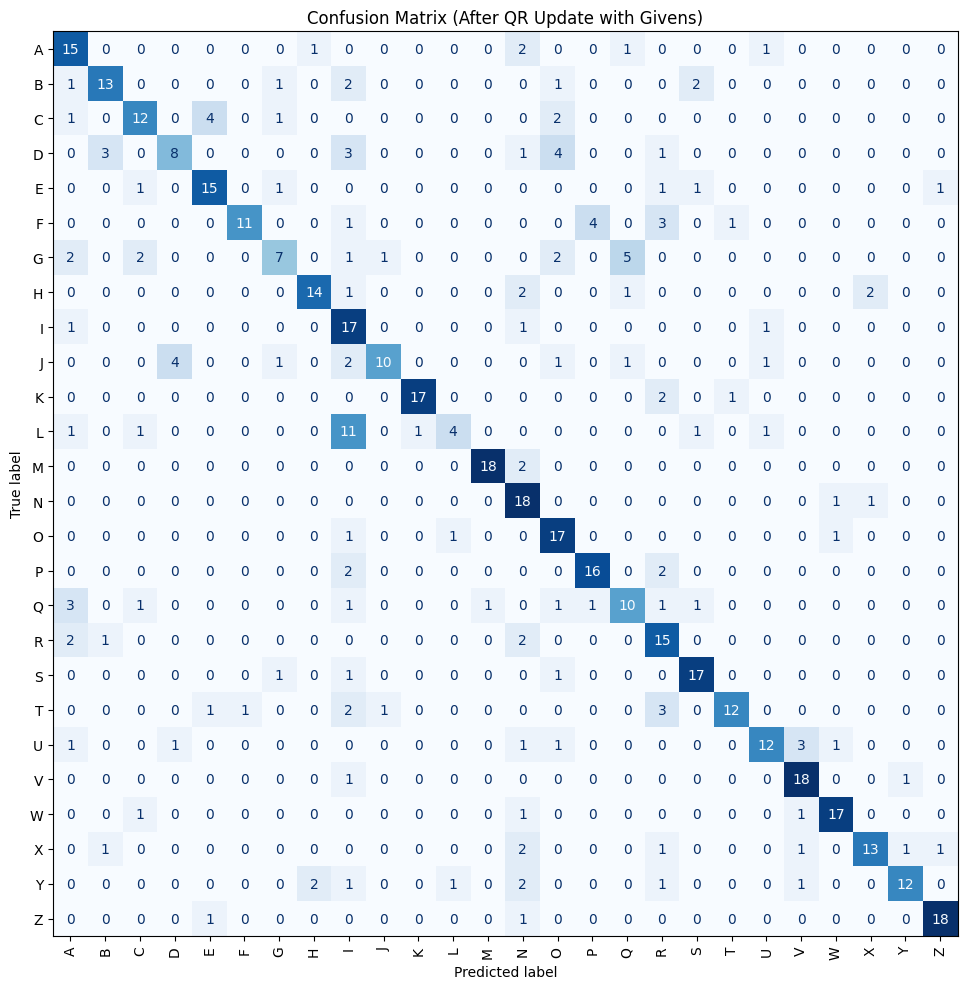


Classification Report (After Update):
              precision    recall  f1-score   support

           A       0.56      0.75      0.64        20
           B       0.72      0.65      0.68        20
           C       0.67      0.60      0.63        20
           D       0.62      0.40      0.48        20
           E       0.71      0.75      0.73        20
           F       0.92      0.55      0.69        20
           G       0.58      0.35      0.44        20
           H       0.82      0.70      0.76        20
           I       0.36      0.85      0.51        20
           J       0.83      0.50      0.62        20
           K       0.94      0.85      0.89        20
           L       0.67      0.20      0.31        20
           M       0.95      0.90      0.92        20
           N       0.51      0.90      0.65        20
           O       0.57      0.85      0.68        20
           P       0.76      0.80      0.78        20
           Q       0.56      0.50      0.5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Convert 1–26 labels to letters A–Z
labels = [chr(64 + i) for i in range(1, 27)]

# Confusion Matrix
cm = confusion_matrix(test_labels_np, predicted_labels_updated, labels=range(1, 27))
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix (After QR Update with Givens)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



# Classification report
print("\nClassification Report (After Update):")
print(classification_report(test_labels_np, predicted_labels_updated, labels=range(1, 27), target_names=labels, zero_division=0))


In [ ]:
# Per-class accuracy before and after
accuracy_per_class_before = {}
accuracy_per_class_after = {}

for label in range(1, 27):
    true_indices = (test_labels_np == label)
    total = np.sum(true_indices)
    correct_before = np.sum(predicted_labels[true_indices] == label)
    correct_after = np.sum(predicted_labels_updated[true_indices] == label)
    accuracy_per_class_before[label] = correct_before / total
    accuracy_per_class_after[label] = correct_after / total

import string

letters = list(string.ascii_uppercase)

print(f"{'Class':<6} {'Before QR Update':>20} {'After QR Update':>20}")
print("=" * 50)

for label in range(1, 27):
    acc_before = accuracy_per_class_before[label]
    acc_after = accuracy_per_class_after[label]
    letter = letters[label - 1]
    print(f"{letter:<6} {acc_before * 100:>18.2f}% {acc_after * 100:>20.2f}%")


Class      Before QR Update      After QR Update
A                   75.00%                75.00%
B                   70.00%                65.00%
C                   65.00%                60.00%
D                   40.00%                40.00%
E                   75.00%                75.00%
F                   50.00%                55.00%
G                   55.00%                35.00%
H                   65.00%                70.00%
I                   85.00%                85.00%
J                   60.00%                50.00%
K                   90.00%                85.00%
L                   30.00%                20.00%
M                   85.00%                90.00%
N                   75.00%                90.00%
O                   85.00%                85.00%
P                   80.00%                80.00%
Q                   45.00%                50.00%
R                   85.00%                75.00%
S                   85.00%                85.00%
T                   

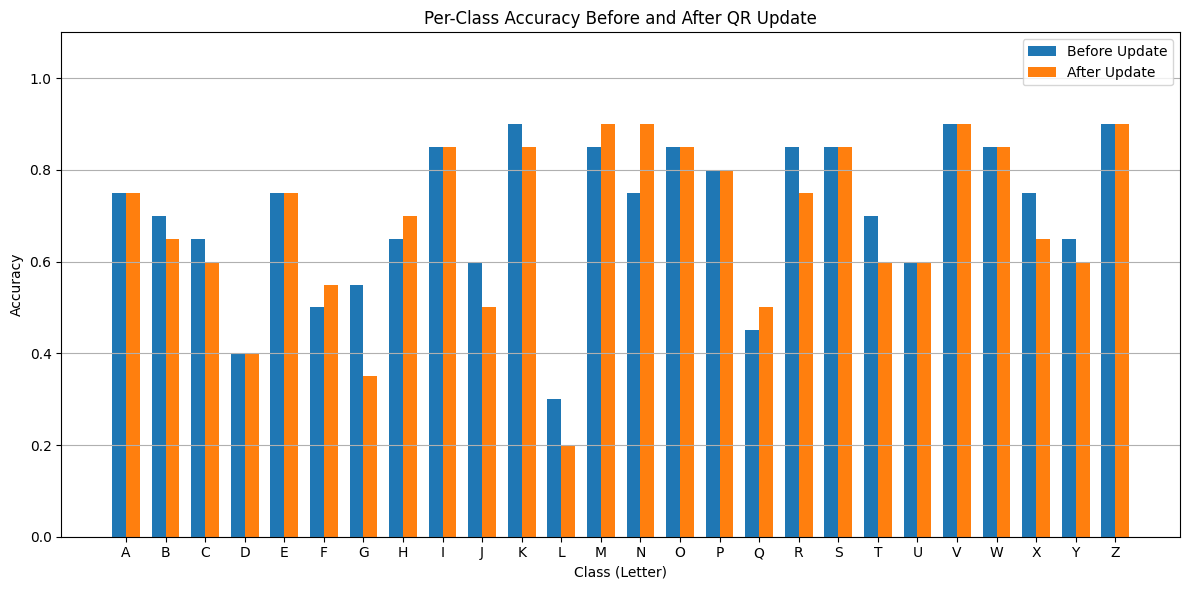

In [ ]:


# Bar chart
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, [accuracy_per_class_before[i] for i in range(1, 27)], width, label='Before Update')
plt.bar(x + width/2, [accuracy_per_class_after[i] for i in range(1, 27)], width, label='After Update')
plt.xlabel('Class (Letter)')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Before and After QR Update')
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()